Importare le librerie


In [22]:
!pip install timm

# --- Inizio Codice ConvNeXt con Augmentation ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from PIL import Image


# Montare Google Drive
drive.mount('/content/drive')

# Configurazione dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device utilizzato: cuda


Caricare i dati

In [23]:
# Percorsi ai dati
train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir  = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Definizione delle trasformazioni
common_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Trasformazioni di augmentation per le immagini di Retinite
augmentation_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Classe personalizzata per aumentare la classe minoritaria
class AugmentedImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, common_transform, augmentation_transform, minority_class=1, replicate_factor=4):
        """
        root: percorso della directory
        common_transform: trasformazione comune per tutte le immagini
        augmentation_transform: trasformazione aggiuntiva per le immagini della classe minoritaria
        minority_class: label della classe da aumentare (es. 1 per "Retinite Pigmentosa")
        replicate_factor: quante volte replicare le immagini minoritarie
        """
        self.dataset = ImageFolder(root, transform=common_transform)
        self.common_transform = common_transform
        self.augmentation_transform = augmentation_transform
        self.minority_class = minority_class

        # Separazione degli indici per le classi
        self.control_indices = [i for i, (_, label) in enumerate(self.dataset.samples) if label != self.minority_class]
        self.minority_indices = [i for i, (_, label) in enumerate(self.dataset.samples) if label == self.minority_class]
        # Replica le immagini minoritarie replicate (oltre alla copia originale) per aumentare il loro peso
        self.rep_minority_indices = self.minority_indices * replicate_factor

        # L'indice totale comprende tutte le immagini di controllo più le repliche della minoritaria
        self.total_indices = self.control_indices + self.rep_minority_indices

    def __len__(self):
        return len(self.total_indices)

    def __getitem__(self, idx):
        real_idx = self.total_indices[idx]
        # Ottieni il percorso e l'etichetta dal dataset originale
        path, label = self.dataset.samples[real_idx]
        # Carica l'immagine in formato PIL
        image = Image.open(path).convert('RGB')
        # Se è immagine della classe minoritaria, applica l'augmentation
        if label == self.minority_class:
            img = self.augmentation_transform(image)
        else:
            img = self.common_transform(image)
        return img, label

# Creazione del dataset di training bilanciato
full_train_data = AugmentedImageFolder(train_dir, common_transform, augmentation_transform, minority_class=1, replicate_factor=4)
# Il test set viene caricato normalmente (senza augmentation)
test_data = ImageFolder(test_dir, transform=common_transform)
print(f"Training dataset bilanciato: {len(full_train_data)} immagini")
print(f"Test dataset: {len(test_data)} immagini")

# Calcolo dello split per training/validation (80/20)
val_size = int(0.2 * len(full_train_data))
train_size = len(full_train_data) - val_size

# DataLoader per il test set (fisso)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Training dataset bilanciato: 1632 immagini
Test dataset: 258 immagini


# Creazione del modello ConvNeXt (usando convnext_tiny da timm)

In [24]:
# Creazione del modello ConvNeXt (utilizziamo convnext_tiny)
model = timm.create_model('convnext_tiny', pretrained=True, num_classes=1)
model = model.to(device)
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


# Funzione di perdita e ottimizzazione

In [25]:
# Loss, ottimizzatore, scheduler
criterion = nn.BCEWithLogitsLoss()  # Combina Sigmoid + BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate iniziale
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# Addestrare il modello

Epoch 1/20 | Train Loss: 0.9481, Acc: 0.5138 | Val Loss: 0.6980, Acc: 0.5031
Epoch 2/20 | Train Loss: 0.7025, Acc: 0.4877 | Val Loss: 0.6901, Acc: 0.5368
Epoch 3/20 | Train Loss: 0.8583, Acc: 0.5314 | Val Loss: 0.7192, Acc: 0.5031
Epoch 4/20 | Train Loss: 0.7073, Acc: 0.5237 | Val Loss: 0.6922, Acc: 0.5644
Epoch 5/20 | Train Loss: 0.7063, Acc: 0.5023 | Val Loss: 0.6916, Acc: 0.5521
Epoch 6/20 | Train Loss: 0.6982, Acc: 0.5092 | Val Loss: 0.7050, Acc: 0.4877
Epoch 7/20 | Train Loss: 0.6964, Acc: 0.5000 | Val Loss: 0.6939, Acc: 0.5061
Early stopping triggered.


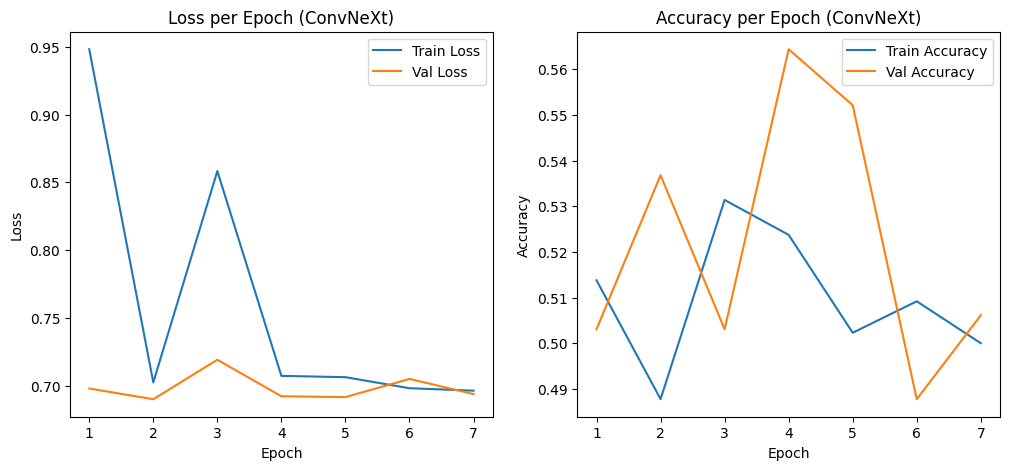

In [26]:
# Variabili per il tracciamento
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
patience, trigger_times = 5, 0

# Ciclo di addestramento con random split ad ogni epoca
for epoch in range(num_epochs):
    # Nuovo split randomico ad ogni epoca
    train_subset, val_subset = random_split(full_train_data, [train_size, val_size])
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=32, shuffle=True)

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validazione
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'convnext_best.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# Grafici di addestramento
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch (ConvNeXt)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch (ConvNeXt)')
plt.legend()
plt.show()

# Valutazione del modello

In [27]:
# Funzione per valutare il modello
def evaluate(model, test_loader):
    model.eval()  # Imposta il modello in modalità di valutazione
    correct = 0
    total = 0

    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la valutazione
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Predizione (0 o 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")

# Valutazione del modello sui dati di test
evaluate(model, test_loader)

Accuracy: 81.0077519379845%


# Matrice di confusione

Confusion Matrix:
[[209   0]
 [ 49   0]]


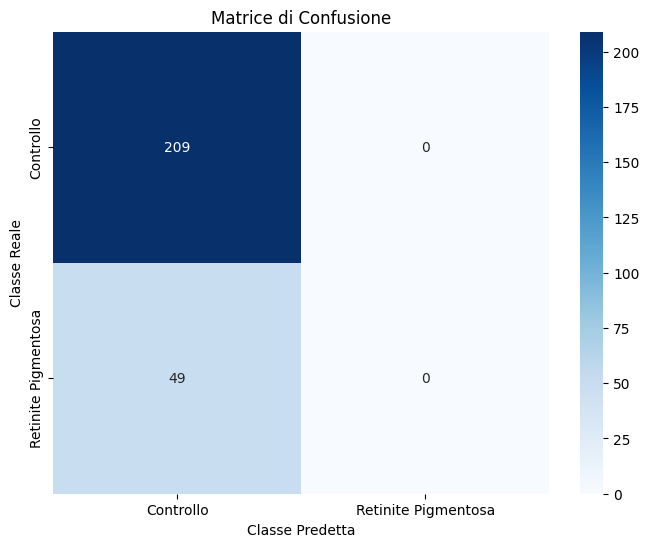

Classification Report:
                     precision    recall  f1-score   support

          Controllo       0.81      1.00      0.90       209
Retinite Pigmentosa       0.00      0.00      0.00        49

           accuracy                           0.81       258
          macro avg       0.41      0.50      0.45       258
       weighted avg       0.66      0.81      0.73       258



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
import torch
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per calcolare e visualizzare la matrice di confusione
def confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = metrics.confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Visualizzazione della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Classe Predetta')
    plt.ylabel('Classe Reale')
    plt.show()

    # Report di classificazione
    print("Classification Report:")
    print(metrics.classification_report(all_labels, all_preds, target_names=class_names))

# Definisci le classi, modifica se necessario
class_names = ['Controllo', 'Retinite Pigmentosa']

# Calcolo e stampa della matrice di confusione
confusion_matrix(model, test_loader, class_names)


Utilizzare il modello

In [21]:
from PIL import Image
import torchvision.transforms as T

# Funzione per fare una previsione su una singola immagine
def predict(model, image_path):
    model.eval()

    # Caricamento e trasformazione dell'immagine
    transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Aggiungi una dimensione per batch
    image = image.to(device)

    # Predizione
    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        output = model(image)  # Passa l'immagine nel modello per ottenere la previsione
        prediction = (output.squeeze() > 0.5).float()  # Applica una soglia di 0.5 per classificare


    print(f"Predizione: {'Retinite Pigmentosa' if prediction == 1 else 'Controllo'}")

# Esegui una previsione su un'immagine
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
predict(model, img_path)

Predizione: Controllo
